In [6]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Statistics 


  Activating environment at `C:\Users\shang\Documents\OCRL\Project\Project.toml`


In [2]:
import Pkg; Pkg.add("Setfield")
using Setfield

    Updating registry at `C:\Users\sriku\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\sriku\Downloads\OCRL Project\OCRL Project\Project.toml`
  No Changes to `C:\Users\sriku\Downloads\OCRL Project\OCRL Project\Manifest.toml`


In [1]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","planar_vehicle.jl")) 

check_dynamic_feasibility (generic function with 1 method)

In [33]:
function combined_dynamics(params::NamedTuple, x::Vector,u::Vector, xref2::Float64,yref2::Float64,dxref2::Float64,dyref2::Float64)
    px, py, θ, δ, v, xsim, ysim, dxsim, dysim = x 
    a, δdot = u 
    
    # Non ego vehicle 
    N = params.N
    x2ic  = params.x2ic 
    Kp = params.Kp
    Kd = params.Kd
    K1 = params.K1    

    
    A = [0 0 1 0;
          0 0 0 1;
          0 0 0 0;
          0 0 0 0.]
    B = [0 0;
          0 0;
          1 0;
          0 1]
    
    X_sim = [xsim, ysim, dxsim, dysim]
    X = [xref2, yref2]
    dX = [dxref2, dyref2]
    U_sim = -Kp*(X_sim[1:2]-X)-Kd*(X_sim[3:4]-dX)
    d = (K1*(X_sim[1:2]-X)/(norm(X_sim[1:2]-X))^2)
    U_sim= U_sim + d
    Xsim_dot = A*X_sim + B*U_sim 
    
   
    # Ego Vehicle
    β = atan(params.lr * δ, params.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / params.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a ]
    #return combined dynamics
    return [xdot;Xsim_dot] 
    
end 

combined_dynamics (generic function with 1 method)

In [3]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real, ref1, ref2)::Vector
    # TODO: input hermite simpson implicit integrator residual
    ẋ1 = combined_dynamics(params, x1, u,ref1[1],ref1[2],ref1[3],ref1[4])
    ẋ2 = combined_dynamics(params, x2, u,ref2[1],ref2[2],ref2[3],ref2[4])
    xh = 0.5*(x1+x2) + (dt/8)*(ẋ1-ẋ2)
    refh = (ref2 + ref1 )/2
    ẋh = combined_dynamics(params,xh,u,refh[1],refh[2],refh[3],refh[4])
    return ẋh - ((-3/(2*dt))*(x1-x2) - 0.25*(ẋ1+ẋ2))
end

hermite_simpson (generic function with 1 method)

In [59]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function vehicle_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xref1, xref2 = params.idx, params.N, params.xref1, params.xref2
    Q, R1, Qf = params.Q, params.R1, params.Qf
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        J += 0.5*(xi[1:5] - xref1[i])'*Q*(xi[1:5] - xref1[i]) + 0.5*ui[1:2]'*R1*ui[1:2] 
    end
    xn = Z[idx.x[N]]
    J += 0.5 * (xn[1:5]-xref1[N])'*Qf*(xn[1:5]-xref1[N])
  
    return J 
end

function vehicle_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    xref2,yref2,dxref2,dyref2 = params.xref2 , params.yref2 , params.dxref2 , params.dyref2 
    
        
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        #print((xref2))
#         params = @set params.xref2 = xref2[i]
#         params = @set params.yref2 = yref2[i]
#         params = @set params.dxref2 = dxref2[i]
#         params = @set params.dyref2 = dyref2[i]
#       params.xref2 = xref2[:,i]
        ref1 = [xref2[i],yref2[i],dxref2[i],dyref2[i]]
        ref2 = [xref2[i+1],yref2[i+1],dxref2[i+1],dyref2[i+1]]
        #hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt,ref1,ref2) 
    end
    
    return c 
end

function vehicle_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx = params.N, params.idx
    x1ic, x2ic = params.x1ic, params.x2ic
    xref1_n= params.xref1[N]
    xref2_n= params.xref2[N]
    xn = Z[idx.x[N]] 
    

    dym_c = vehicle_dynamics_constraints(params,Z)
    eq_c = [[x1ic;x2ic]-Z[idx.x[1]]; dym_c; xref1_n[1]-xn[1]] 
    return eq_c 
end

function inequality_constraint(params::NamedTuple, Z::Vector)

    N, idx, xref1, xref2 = params.N, params.idx, params.xref1, params.xref2
    # one for distance between two cars, two for the upper and lower bounds of road
    
    ineq_c = zeros(eltype(Z),N-1)
    for i = 1:N-1
        x = Z[idx.x[i]]
        pos1 = x[1:2]
        pos2 = x[6:7]
        dist = norm(pos1-pos2)^2 #distance between the cars
        ineq_c[i] = dist
    end
#     xn = Z[idx.x[N]]
#     pos1 = xn[1:2]
#     pos2 = xn[6:7]
#     xrefn1 = xref1[N][1:2]
#     xrefn2 = xref2[1:2]
#     ineq_c[end-1:end] = [norm(pos1-xrefn1)^2;norm(pos2-xrefn2)^2]
    return ineq_c 
end

"""
    vehicle_path

Function for returning collision free trajectories for 2 cars. 

Outputs:
    x1::Vector{Vector}  # state trajectory for car 1 
    x2::Vector{Vector}  # state trajectory for car 2 
    u1::Vector{Vector}  # control trajectory for car 1 
    u2::Vector{Vector}  # control trajectory for car 2 
    t_vec::Vector
    params::NamedTuple

The resulting trajectories should have dt=0.2, tf = 8, N = 100

"""
function vehicle_path(;verbose=true)
    
    # problem size 
    nx = 9
    nu = 2
    dt = 0.1
    tf = 10
    t_vec = 0:dt:tf 
    N = length(t_vec)
    L = 2.8
    lr = 1.6
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial conditions and goal states 
    x1ic = [-1.5,-1.5,0,0,0] # ic for quad 1 
    x2ic = [1.5;-1.5;0;0] # ic for quad 2 
    ### Reference Trajectories
    x1 = range(1, stop=100, length=N);
    y1 = 3*sin.((2*pi/100)*x1);
    theta1 = zeros(N);
    δ1 = zeros(N);
    v1 = 5*ones(N);
    A1 = hcat(x1,y1,theta1,δ1,v1)
    xref1 = [A1[i,:] for i in 1:size(A1,1)]

    x2 = range(1, stop=100, length=N);
    y2 = 3*sin.((2*pi/100)*x2);
    xdot = 12*ones(N);
    ydot = (6*pi/100)*cos.((2*pi/100.)*x2).*xdot
    
#     A2 = hcat(x2,y2,xdot,ydot);
#     A2_ = [A2[i,:] for i in 1:size(A2,1)]
#     xref2 = A2;
    
    Q = diagm([20,20,0.01,0.01,0.01])
    Qf = diagm([10,10,0.01,0.01,0.01])
    R1 = diagm([10,10])
    
    Kp = 7
    Kd = 4
    K1 = 5
    
    # load all useful things into params 
    # TODO: include anything you would need for a cost function (like a Q, R, Qf if you were doing an 
    # LQR cost)
    params = (x1ic=x1ic,
              x2ic=x2ic,
              xic = [x1ic;x2ic],
              xref1 = xref1,
              xref2 = x2,
              yref2 = y2,
              dxref2 = xdot,
              dyref2 = ydot,
              dt = dt,
              N = N,
              idx = idx,
              Q = Q,
              R1 = R1,
              Qf = Qf,
               L = L,
              lr = lr,
        Kp = Kp,
        Kd = Kd, 
        K1 = K1
        )    
    #print(params.xref2)
    ### Primal Bounds
    ### inf bound for angular velocity and steering rate
    #x_l  [x1, y1, theta, delta,velocity, x2, y2, x2dot, y2dot,deltadot, a]
    x_l = [[-Inf,-8,-pi/2,-pi/3,-Inf, -Inf,-10,0,-15, -20,-20] for i = 1:N-1]
    x_l = reduce(vcat,x_l)
    #remove the u at last time step
    x_l = [x_l;[-Inf,-10,-pi/2,-pi/3,-Inf, -Inf,-15,-20,-20]]
    
    x_u = [[Inf,10,pi/3,pi/3,200, Inf,10,20,20,20,20] for i = 1:N-1]
    x_u = reduce(vcat,x_u)
    x_u = [x_u;[Inf,10,pi/2,pi/3,200,Inf,10,20,20]]
    
    # Assume each car is 2 meters wide and 2.5 meters long
    c_l = 8*ones(N-1)
#     c_l[end-1:end] .= 0
    c_u = Inf*ones(N-1)
#     c_u[end-1:end] .= 3 
    
    ## initial guess
    z0 = 0.01*randn(idx.nz)
    diff_type = :auto

    
    Z = fmincon(vehicle_cost,vehicle_equality_constraint,inequality_constraint,
            x_l,x_u,c_l,c_u,z0,params, diff_type;
            tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    x1 = [Z[idx.x[i]][1:5]  for i = 1:N]
    x2 = [Z[idx.x[i]][6:9]  for i = 1:N]
    u1 = [Z[idx.u[i]][1:2]  for i = 1:(N-1)]
        
    return x1, x2, u1, t_vec, params 
end

vehicle_path

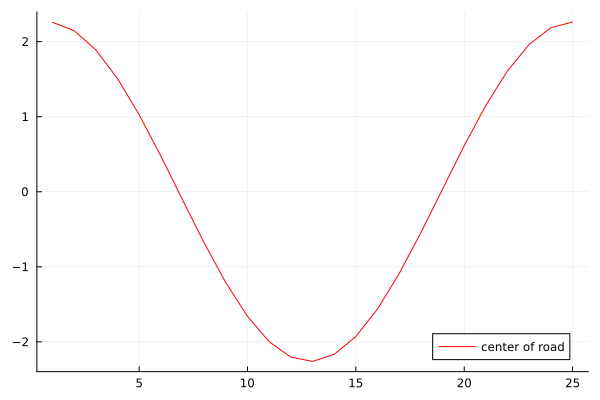

In [25]:
tf = 12
dt = 0.5
t_vec = 0:dt:tf 
N = length(t_vec)
x2 = range(1, stop=100, length=N);
xdot = 12*ones(N);
ydot=(6*pi/100)*cos.((2*pi/100).*x2).*xdot
plot(ydot, color = :red, label = "center of road")

In [17]:
x

1.0:4.95:100.0

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:  1009190
Number of nonzeros in inequality constraint Jacobian.:   110900
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1109
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      806
                     variables with only upper bounds:      101
Total number of equality constraints.................:      910
Total number of inequality constraints.......

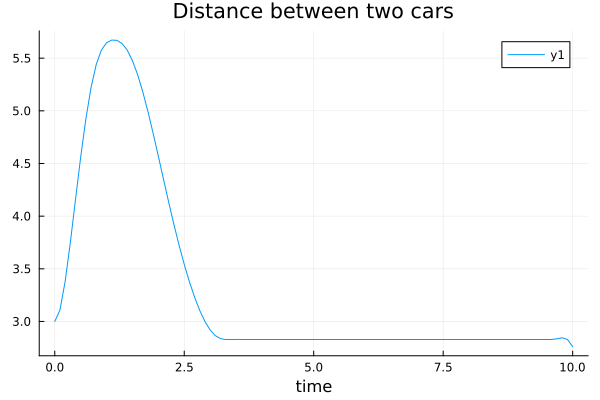

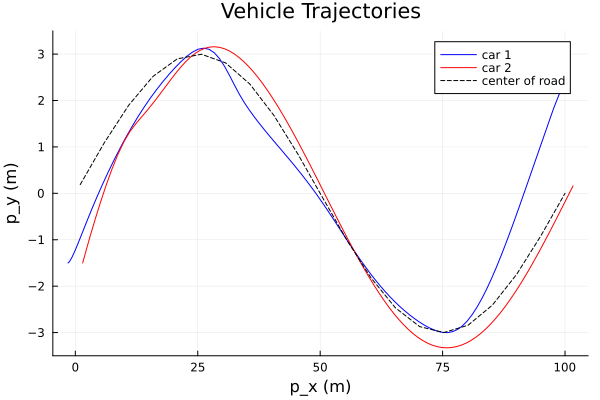

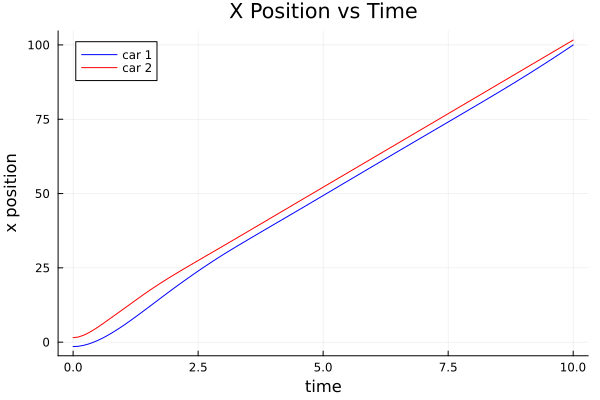

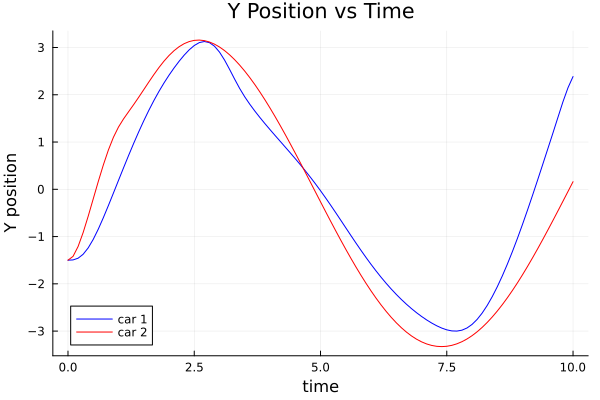

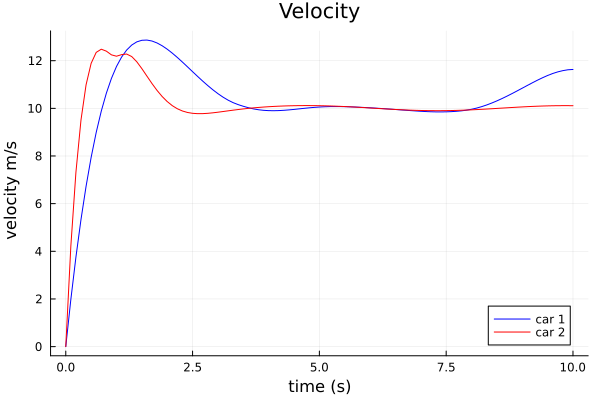

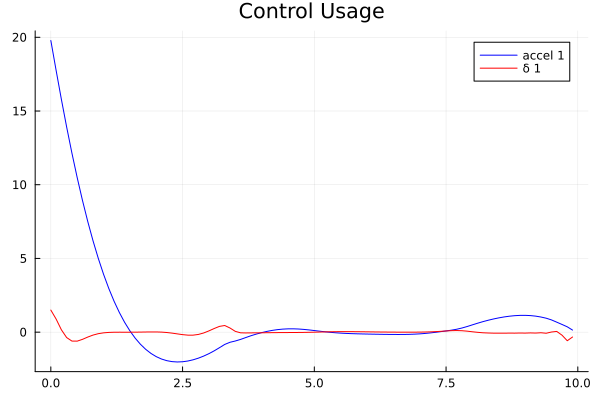

In [60]:
tf = 10
dt = 0.5
t_vec = 0:dt:tf 
N = length(t_vec)
x = range(1, stop=100, length=N);
y = 3*sin.((2*pi/100)*x);

X1, X2, U1,t_vec, params  = vehicle_path(verbose=true)
    


distances = [distance_between_cars(x1[1:2],x2[1:2]) for (x1,x2) in zip(X1,X2)]
display(plot(t_vec,reduce(vcat, distances),xlabel = "time", title = "Distance between two cars"))

        
X1m = hcat(X1...)
X2m = hcat(X2...)

    
plot(X1m[1,:], X1m[2,:], color = :blue,title = "Vehicle Trajectories", label = "car 1", ylims = [-3.5,3.5])
plot!(X2m[1,:], X2m[2,:], color = :red, label = "car 2",xlabel = "p_x (m)", ylabel = "p_y (m)", legend=:topright)
# plot!(x,y.+3, color = :black, label = "upper bound road")
# plot!(x,y.-3, color = :black, label = "lower bound road")
display(plot!(x,y, color = :black, label = "center of road", ls=:dash))
# plot!(3*ones(100),ls = :dash, color = :red, label = "upper road bound")
# plot!(zeros(100), color = :red, label = "center of road")
# display(plot!(-3*ones(100),ls = :dash, color = :red, label = "lower road bound"))
    


plot(t_vec, X1m[1,:], color = :blue,label = "car 1")
display(plot!(t_vec, X2m[1,:], color = :red,title = "X Position vs Time", xlabel = "time", ylabel="x position", label = "car 2"))
plot(t_vec, X1m[2,:], color = :blue,label = "car 1")
display(plot!(t_vec, X2m[2,:], color = :red,title = "Y Position vs Time", xlabel = "time", ylabel="Y position", label = "car 2"))

        
plot(t_vec, X1m[5,:], color = :blue,title = "Velocity", label = "car 1")
V_2 = X2m[3,:].^2 + X2m[4,:].^2
V_2 = V_2.^0.5
display(plot!(t_vec, V_2, color = :red, label = "car 2",xlabel = "time (s)", ylabel = " velocity m/s"))
    
plot(t_vec[1:end-1],reduce(hcat,U1)'[:,1], color = :blue,title = "Control Usage", label = "accel 1")
plot!(t_vec[1:end-1],reduce(hcat,U1)'[:,2], color = :red,title = "Control Usage", label = "δ 1")



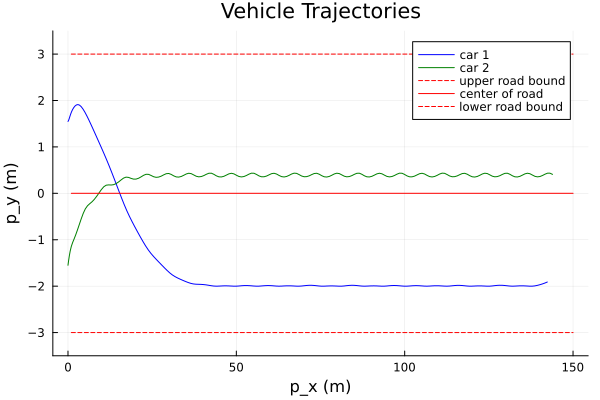

In [54]:
plot(X1m[1,:], X1m[2,:], color = :blue,title = "Vehicle Trajectories", label = "car 1", ylims = [-3.5,3.5])
plot!(X2m[1,:], X2m[2,:], color = :green, label = "car 2",xlabel = "p_x (m)", ylabel = "p_y (m)", legend=:topright)
plot!(3*ones(150),ls = :dash, color = :red, label = "upper road bound")
plot!(zeros(150), color = :red, label = "center of road")
display(plot!(-3*ones(150),ls = :dash, color = :red, label = "lower road bound"))

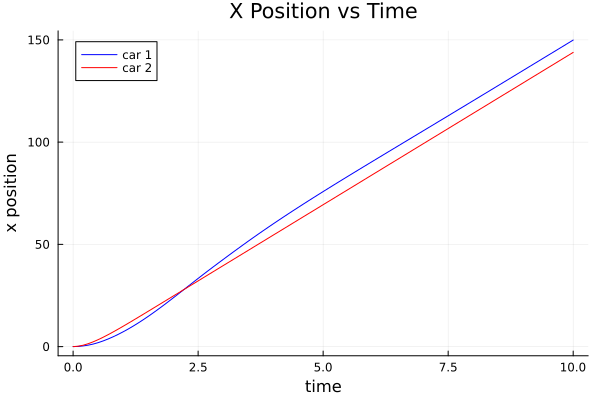

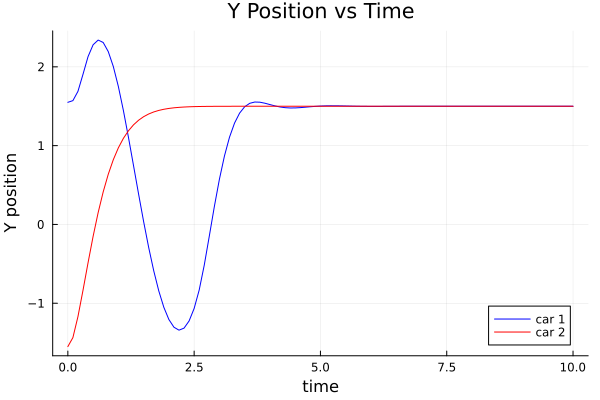

In [9]:
plot(t_vec, X1m[1,:], color = :blue,label = "car 1")
display(plot!(t_vec, X2m[1,:], color = :red,title = "X Position vs Time", xlabel = "time", ylabel="x position", label = "car 2"))
plot(t_vec, X1m[2,:], color = :blue,label = "car 1")
display(plot!(t_vec, X2m[2,:], color = :red,title = "Y Position vs Time", xlabel = "time", ylabel="Y position", label = "car 2"))


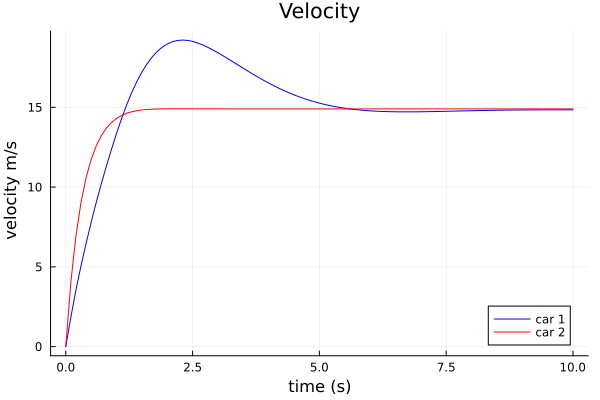

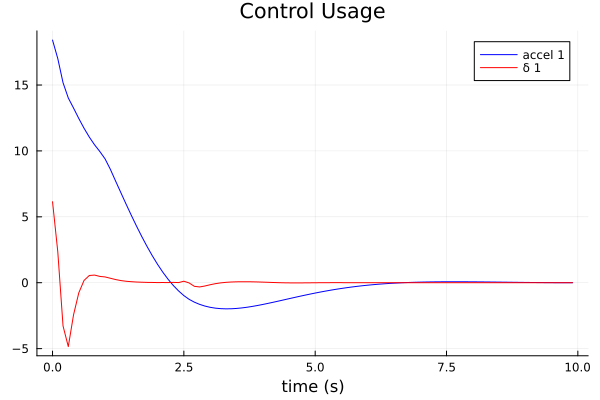

In [11]:
plot(t_vec, X1m[5,:], color = :blue,title = "Velocity", label = "car 1")
V_2 = X2m[3,:].^2 + X2m[4,:].^2
V_2 = V_2.^0.5
display(plot!(t_vec, V_2, color = :red, label = "car 2",xlabel = "time (s)", ylabel = " velocity m/s"))
    
plot(t_vec[1:end-1],reduce(hcat,U1)'[:,1], color = :blue,title = "Control Usage", label = "accel 1",xlabel = "time (s)")
plot!(t_vec[1:end-1],reduce(hcat,U1)'[:,2], color = :red,title = "Control Usage", label = "δ 1",xlabel = "time (s)")